In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error


### Import  DataSet

In [11]:
df_mensual=pd.read_csv('ventas_m.csv')
df_mensual.head()

,fecha,ventas,cono sin aderezo,freddo simple,tulipan simple
0,2022-January,6545.72,358,1205,32
1,2022-February,8374.50,449,1409,48
2,2022-March,9887.53,518,1817,35
3,2022-April,10777.40,567,1840,54
4,2022-May,10079.33,552,1803,42


In [12]:
df_mensual = df_mensual.rename(columns={
    'fecha': 'date',
    'ventas': 'total_sales',
    'cono sin aderezo': 'cone_without_topping',
    'freddo simple': 'simple_freddo',
    'tulipan simple': 'simple_tulip'
})

df_mensual.head()

,date,total_sales,cone_without_topping,simple_freddo,simple_tulip
0,2022-January,6545.72,358,1205,32
1,2022-February,8374.50,449,1409,48
2,2022-March,9887.53,518,1817,35
3,2022-April,10777.40,567,1840,54
4,2022-May,10079.33,552,1803,42


Visualization of variables

In [13]:
df_mensual.describe()

,total_sales,cone_without_topping,simple_freddo,simple_tulip
count,36.00000,36.000000,36.000000,36.000000
mean,11984.08500,732.527778,2229.388889,56.416667
std,2061.11196,167.760115,476.236273,16.141119
min,6545.72000,358.000000,1205.000000,25.000000
25%,10766.96000,618.500000,1920.500000,46.750000
50%,11691.12000,721.000000,2158.500000,55.000000
75%,13458.23500,865.500000,2514.250000,62.250000
max,15880.43000,1055.000000,3409.000000,104.000000


In [14]:
df_mensual.isnull().sum()

date                    0
total_sales             0
cone_without_topping    0
simple_freddo           0
simple_tulip            0
dtype: int64

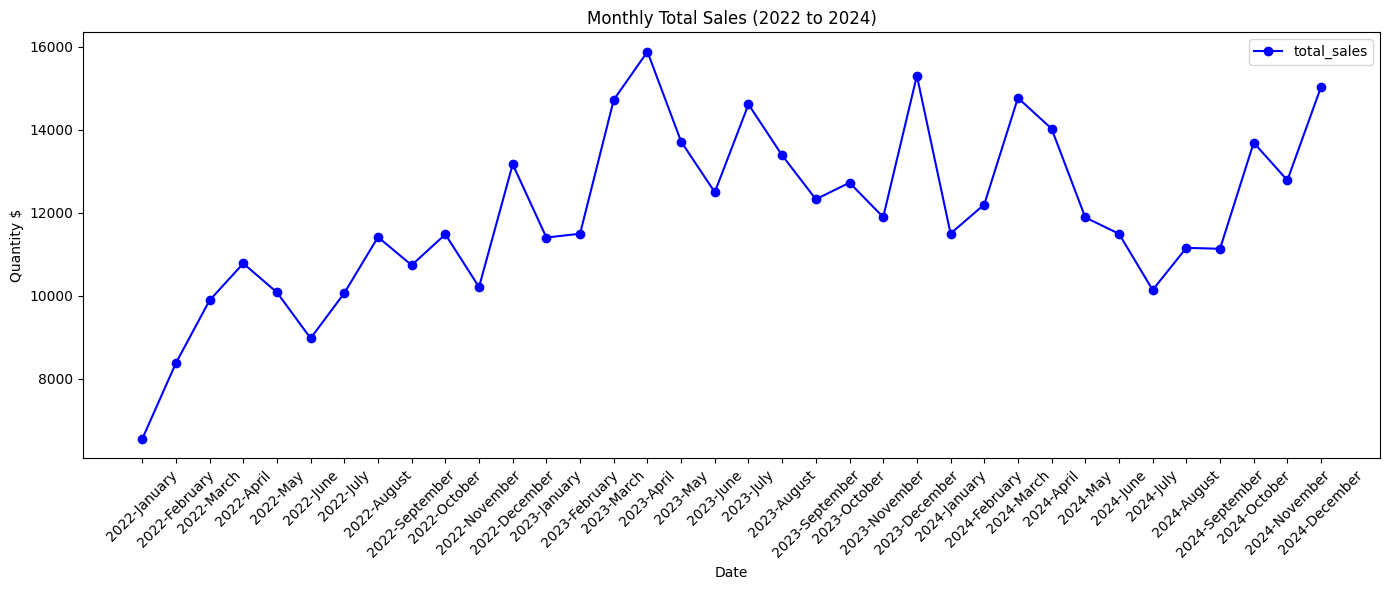

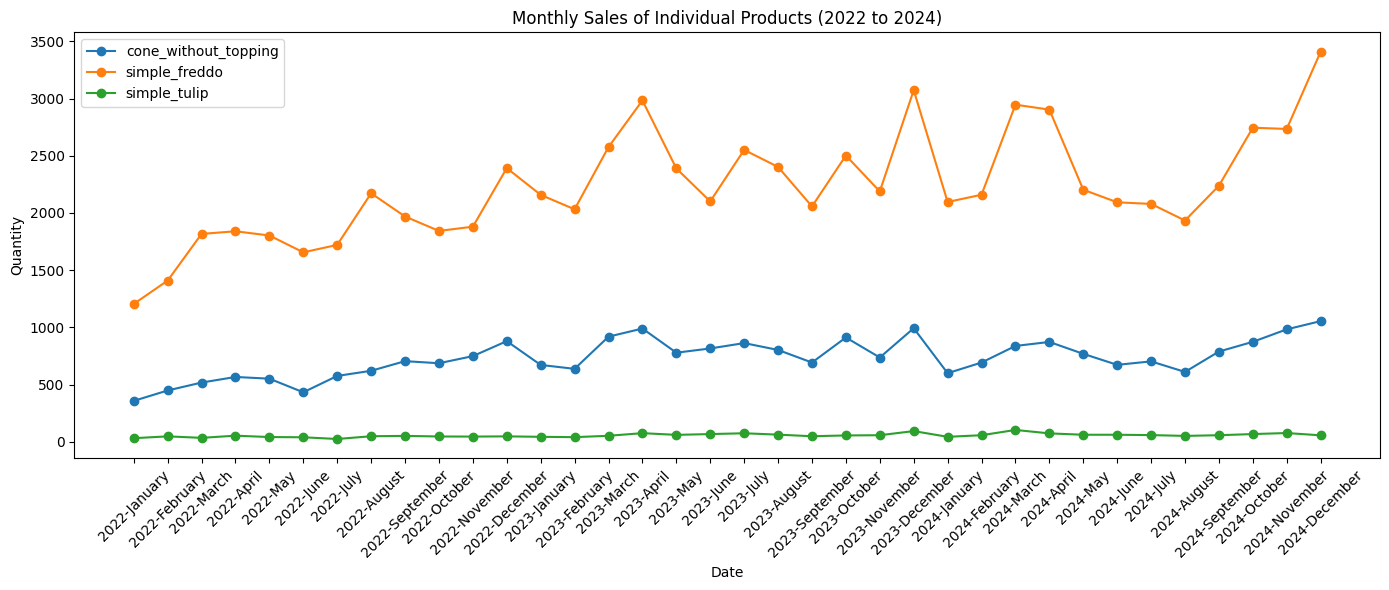

In [15]:
# --- 1. Plot only total_sales ---
plt.figure(figsize=(14,6))
plt.plot(df_mensual['date'], df_mensual['total_sales'], marker='o', color='blue', label="total_sales")
plt.title("Monthly Total Sales (2022 to 2024)")
plt.xlabel("Date")
plt.ylabel("Quantity $")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# --- 2. Plot all product-level variables (excluding total_sales) ---
numeric_columns = df_mensual.select_dtypes(include=['float64','int64']).columns

product_columns = [col for col in numeric_columns if col !="total_sales"]

plt.figure(figsize=(14,6))
for col in product_columns:
    plt.plot(df_mensual['date'], df_mensual[col], marker='o', label=col)

plt.title("Monthly Sales of Individual Products (2022 to 2024)")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### ADF test

La prueba ADF (Augmented Dickey–Fuller) es un test estadístico utilizado para determinar si una serie temporal es estacionaria o si contiene una raíz unitaria (unit root), condición característica de series no estacionarias, es decir, series con tendencia o estructura cambiante en el tiempo.

La estacionariedad es un requisito fundamental para modelos como ARIMA y SARIMA, ya que estos métodos suponen que la serie debe tener:

media constante,

varianza constante,

autocorrelaciones que dependen solo del rezago y no del tiempo.

Una serie no estacionaria suele presentar tendencias, cambios estructurales o variabilidad creciente, lo que imposibilita una modelación confiable.
Por ello, el ADF es una primera etapa obligatoria antes de ajustar modelos ARIMA/SARIMA.

In [16]:
def adf_test(series, title="Series"):
    print(f"=== ADF Test: {title} ===")
    result = adfuller(series, autolag="AIC")
    
    labels = [
        "ADF Statistic",
        "p-value",
        "# Lags Used",
        "Number of Observations Used"
    ]
    
    for value, label in zip(result[0:4], labels):
        print(f"{label}: {value}")
    
    print("\nCritical values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    
    print("=============================\n")



In [17]:
adf_test(df_mensual['total_sales'], title="Monthly Sales")



=== ADF Test: Monthly Sales ===
ADF Statistic: -3.4769612615232064
p-value: 0.008598870723729297
# Lags Used: 0
Number of Observations Used: 35

Critical values:
   1%: -3.6327426647230316
   5%: -2.9485102040816327
   10%: -2.6130173469387756



In [18]:
# Apply the ADF test to the monthly sales
adf_test(df_mensual['cone_without_topping'], title="Cone Without Topping")
adf_test(df_mensual['simple_freddo'], title="Simple Freddo")
adf_test(df_mensual['simple_tulip'], title="Simple Tulip")

=== ADF Test: Cone Without Topping ===
ADF Statistic: -2.9947995720325564
p-value: 0.035382917171897725
# Lags Used: 0
Number of Observations Used: 35

Critical values:
   1%: -3.6327426647230316
   5%: -2.9485102040816327
   10%: -2.6130173469387756

=== ADF Test: Simple Freddo ===
ADF Statistic: -2.883501275064256
p-value: 0.047300488572395875
# Lags Used: 0
Number of Observations Used: 35

Critical values:
   1%: -3.6327426647230316
   5%: -2.9485102040816327
   10%: -2.6130173469387756

=== ADF Test: Simple Tulip ===
ADF Statistic: -4.086888318322984
p-value: 0.0010180020480390626
# Lags Used: 0
Number of Observations Used: 35

Critical values:
   1%: -3.6327426647230316
   5%: -2.9485102040816327
   10%: -2.6130173469387756



### ACF & PACF

Fundamento teórico

La ACF muestra la autocorrelación entre el valor de la serie y sus rezagos.
La PACF muestra la correlación neta en un rezago, eliminando intermediarios.

Se usan para:

ACF → identificar q

PACF → identificar p

- The Autocorrelation Function(ACF) measures total autocorrelation, showing how strongly past values influence present values across different time lags.

- The Partial Autocorrelation Function (PACF) isolates direct relationships between observations and their lagged values, controlling for intervening lags.


=== ACF & PACF for: total_sales ===


<Figure size 1200x400 with 0 Axes>

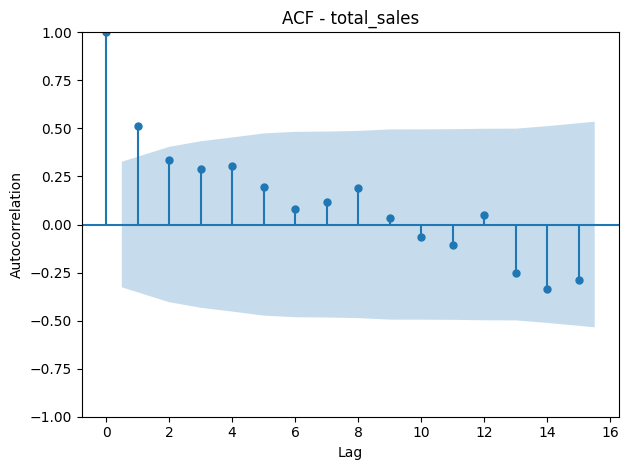

<Figure size 1200x400 with 0 Axes>

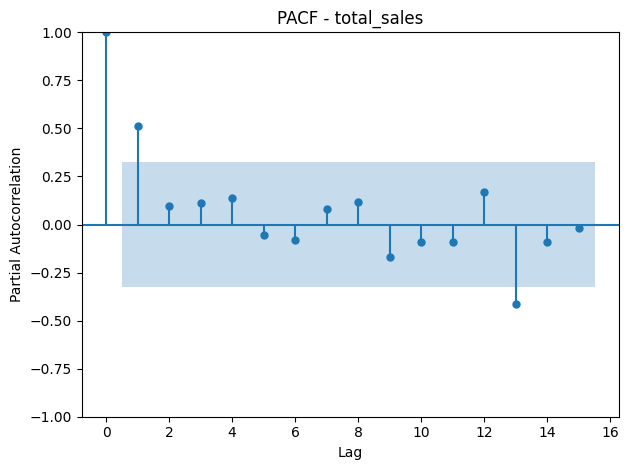


=== ACF & PACF for: cone_without_topping ===


<Figure size 1200x400 with 0 Axes>

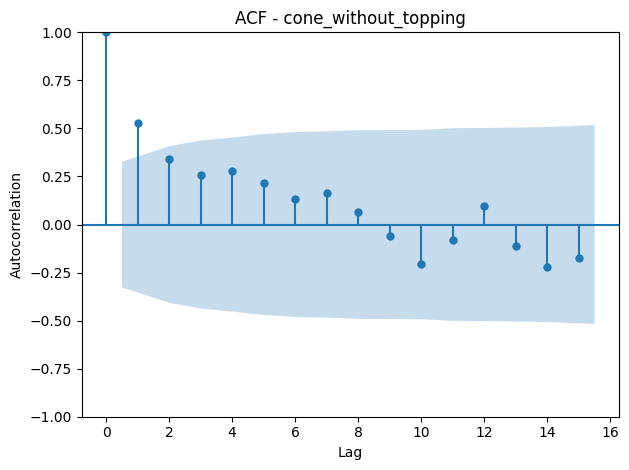

<Figure size 1200x400 with 0 Axes>

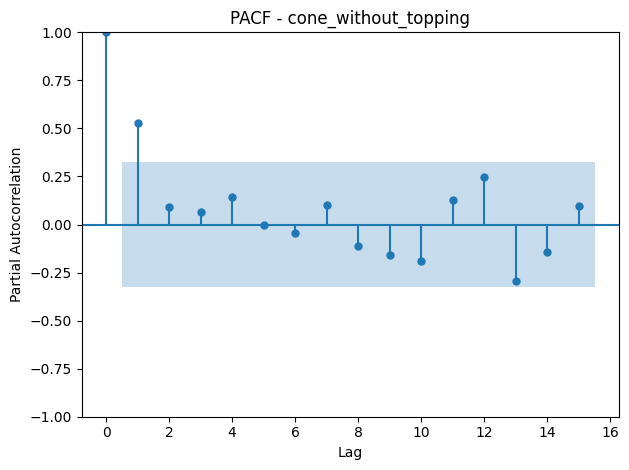


=== ACF & PACF for: simple_freddo ===


<Figure size 1200x400 with 0 Axes>

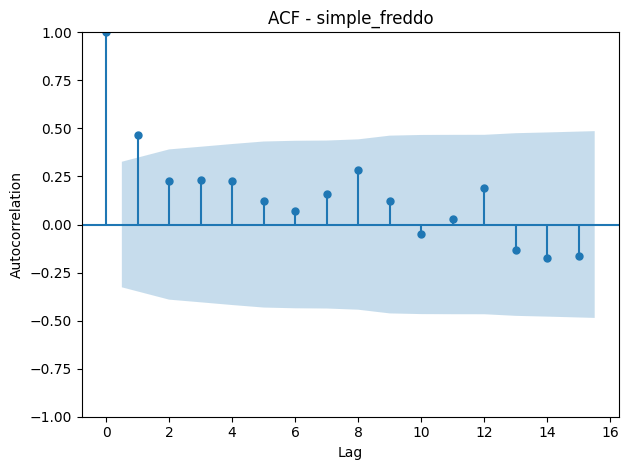

<Figure size 1200x400 with 0 Axes>

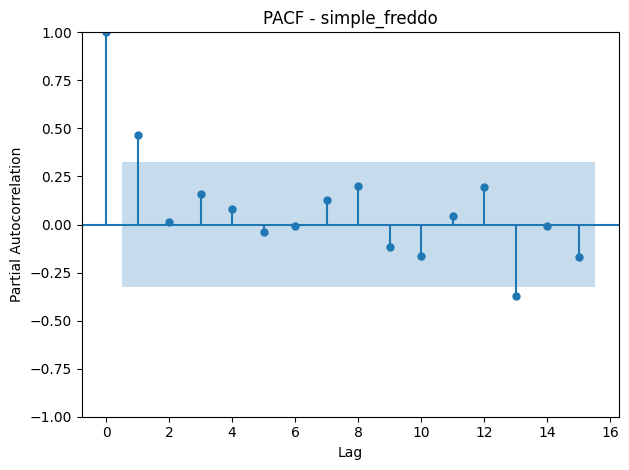


=== ACF & PACF for: simple_tulip ===


<Figure size 1200x400 with 0 Axes>

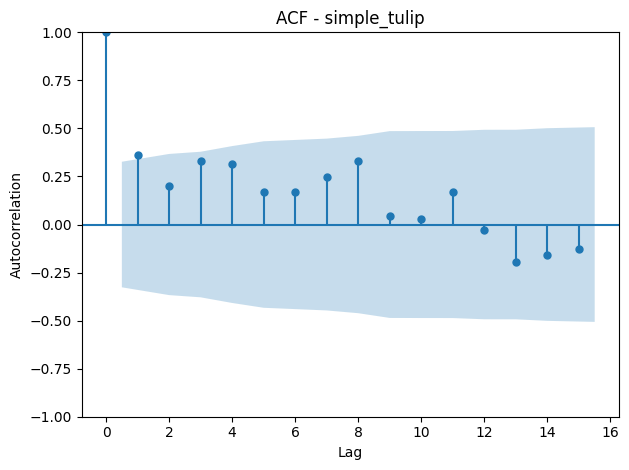

<Figure size 1200x400 with 0 Axes>

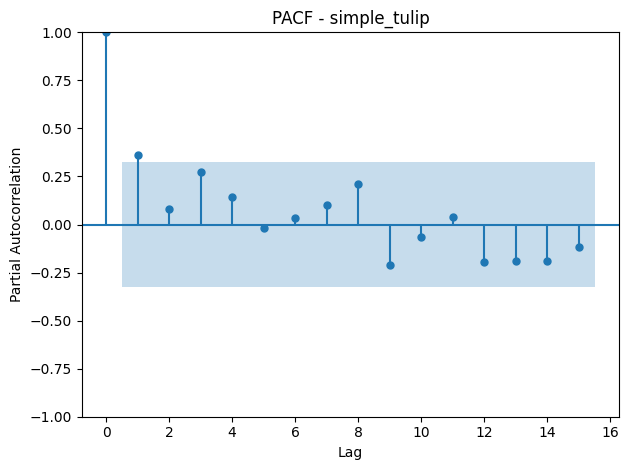

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Select only numeric columns (excluding date)
numeric_columns = df_mensual.select_dtypes(include=['float64','int64']).columns

for col in numeric_columns:
    series = df_mensual[col]

    print(f"\n=== ACF & PACF for: {col} ===")

    # ACF plot
    plt.figure(figsize=(12,4))
    plot_acf(series, lags=15)
    plt.title(f"ACF - {col}")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.tight_layout()
    plt.show()

    # PACF plot
    plt.figure(figsize=(12,4))
    plot_pacf(series, lags=15, method="ywm")
    plt.title(f"PACF - {col}")
    plt.xlabel("Lag")
    plt.ylabel("Partial Autocorrelation")
    plt.tight_layout()
    plt.show()


K


### IMPLEMENT AUTO-ARIMA

Este código aplica Auto-ARIMA para determinar de manera automática y objetiva el mejor modelo ARIMA para cada serie temporal del conjunto de datos. La selección se basa en criterios AIC/BIC, utilizando la información de estacionariedad obtenida con la prueba ADF y descartando estacionalidad por falta de evidencia en ACF/PACF. El proceso es eficiente, reproducible y garantiza consistencia en el modelado de las ventas mensuales de cada producto.

La expresión “falta de evidencia en ACF/PACF” significa que las gráficas de autocorrelación y autocorrelación parcial no muestran patrones estructurados —como picos en rezagos estacionales, decaimiento lento o cortes abruptos— que justifiquen la presencia de estacionalidad o componentes AR o MA de alto orden. En ausencia de estos patrones, se asume que la serie no presenta estacionalidad significativa y que un modelo ARIMA no estacional con órdenes bajos es suficiente.

In [20]:
from pmdarima import auto_arima
# (Criterio de Información de Akaike)

# Es una medida estadística que sirve para evaluar qué tan bueno es un modelo, comparando muchos modelos diferentes entre sí.


# Select numeric columns (all variables except date)
numeric_columns = df_mensual.select_dtypes(include=['float64','int64']).columns

results = {}   # store models

for col in numeric_columns:
    print(f"\n===============================")
    print(f" AUTO-ARIMA for variable: {col}")
    print(f"===============================")

    series = df_mensual[col]

    model = auto_arima(
        series,
        start_p=0, max_p=4,
        start_q=0, max_q=4,
        d=0,                     # assumed stationary after ADF test
        seasonal=False,          # monthly data without strong seasonality
        trace=True,              # display tested models
        error_action="ignore",
        suppress_warnings=True,
        stepwise=True
    )

    results[col] = model
    print(model.summary())



 AUTO-ARIMA for variable: total_sales
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=781.360, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=646.812, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=744.047, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=644.072, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=645.628, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=717.384, Time=0.32 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=644.298, Time=0.09 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 2.119 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(1, 0, 1)   Log L

- AUTO-ARIMA for variable: total_sales
- -Best model:  ARIMA(1,0,1)(0,0,0)[0] 


- AUTO-ARIMA for variable: cone_without_topping
- -Best model:  ARIMA(1,0,0)(0,0,0)[0]

- AUTO-ARIMA for variable: simple_freddo
- -Best model:  ARIMA(1,0,0)(0,0,0)[0]

- AUTO-ARIMA for variable: simple_tulip
- -Best model:  ARIMA(1,0,1)(0,0,0)[0] 

### Split DataSet

In [21]:
df_mensual["date"] = pd.to_datetime(df_mensual["date"])

# Establecer la columna Fecha como índice
df_mensual = df_mensual.set_index("date")

# Ordenar el índice cronológicamente
df_mensual = df_mensual.sort_index()


split_date = "2024-05-01"

# Select numeric columns (all variables except the date)
numeric_columns = df_mensual.select_dtypes(include=['float64', 'int64']).columns

# Dictionaries to store the training and testing series
train_series = {}
test_series = {}

for col in numeric_columns:
    train_series[col] = df_mensual.loc[df_mensual.index < split_date][col]
    test_series[col]  = df_mensual.loc[df_mensual.index >= split_date][col]

# Display the processed variables
print("Processed variables:")
for col in numeric_columns:
    print(f"- {col}")



Processed variables:
- total_sales
- cone_without_topping
- simple_freddo
- simple_tulip


C:\Users\Usuario\AppData\Local\Temp\ipykernel_3572\2509840560.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mensual["date"] = pd.to_datetime(df_mensual["date"])


In [22]:
train_series["total_sales"].head()

date
2022-01-01     6545.72
2022-02-01     8374.50
2022-03-01     9887.53
2022-04-01    10777.40
2022-05-01    10079.33
Name: total_sales, dtype: float64

### ARIMA MODEL

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== ARIMA Forecast for: total_sales ===


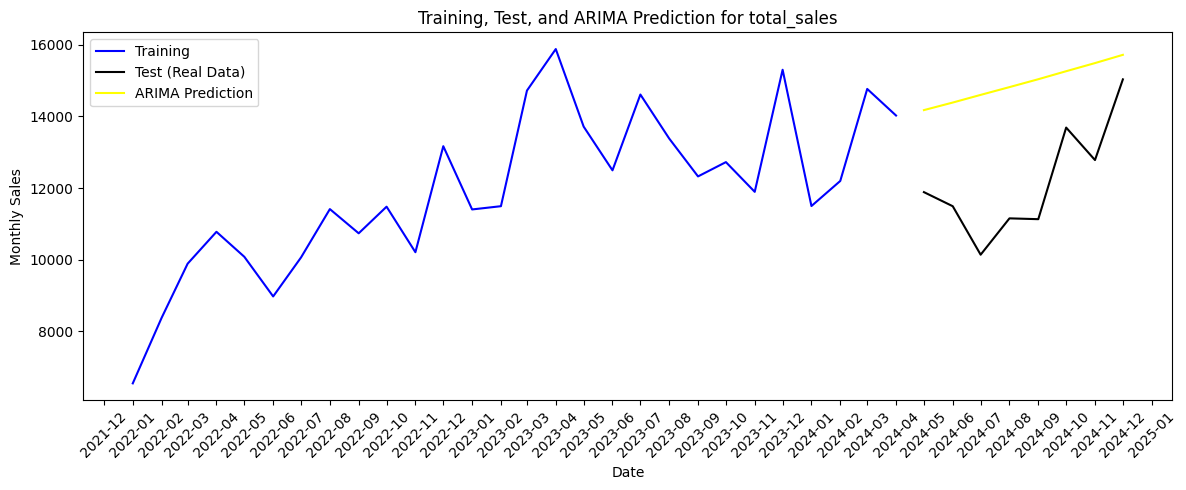


=== ARIMA Forecast for: cone_without_topping ===


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


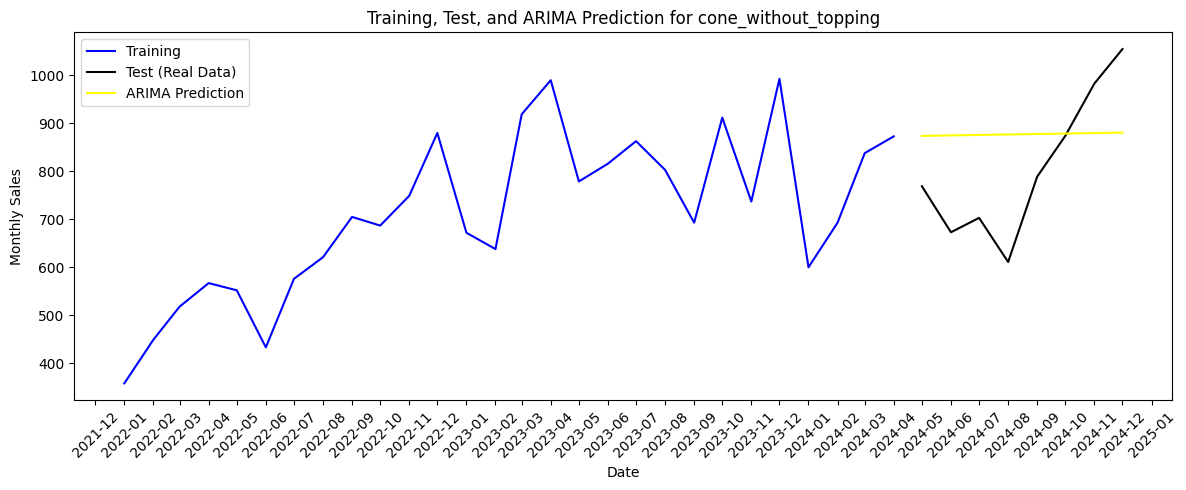


=== ARIMA Forecast for: simple_freddo ===


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


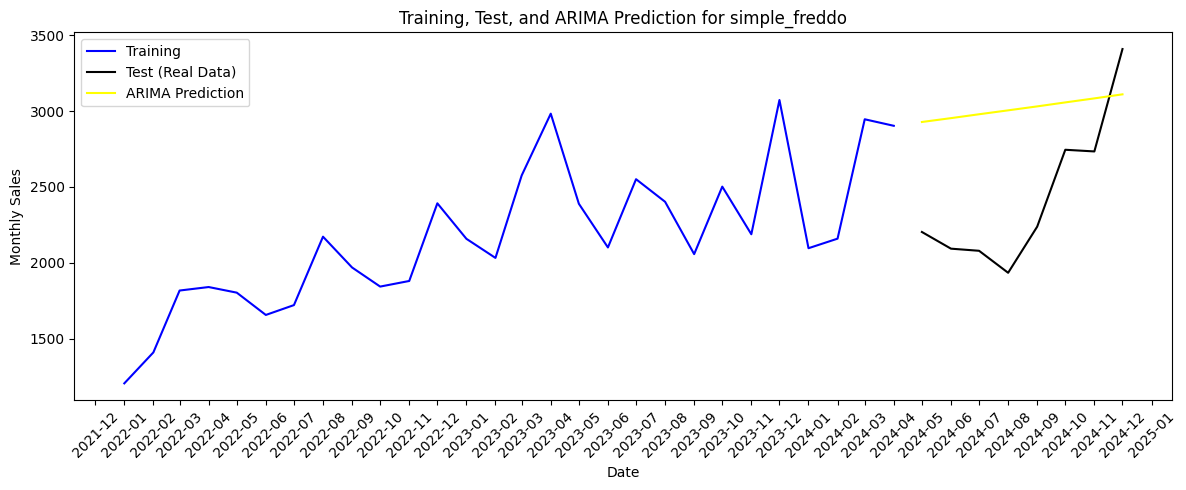


=== ARIMA Forecast for: simple_tulip ===


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


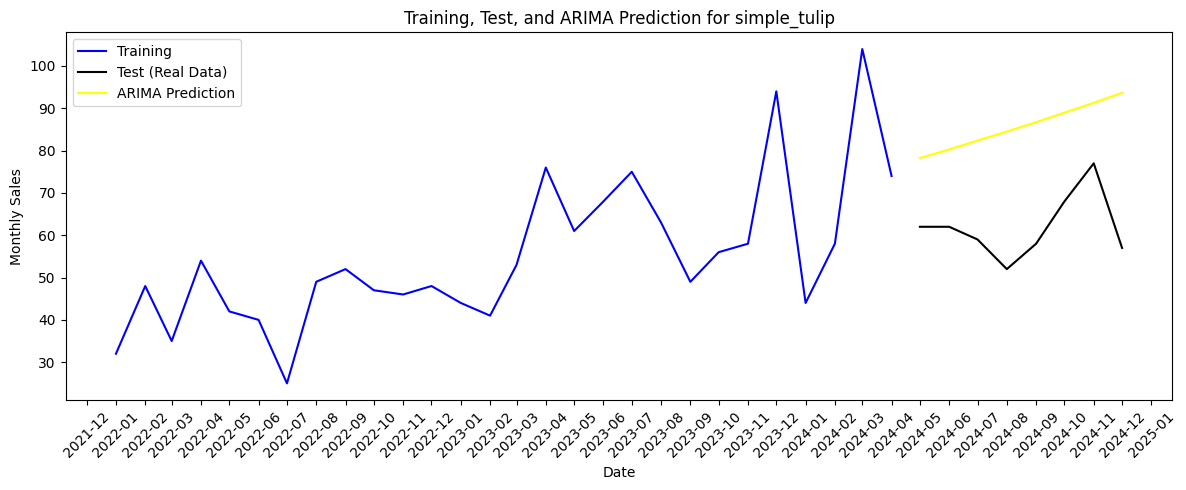

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Dictionary of ARIMA orders found by Auto-ARIMA
arima_orders = {
    "total_sales": (1, 0, 1),
    "cone_without_topping": (1, 0, 0),
    "simple_freddo": (1, 0, 0),
    "simple_tulip": (1, 0, 1)
}

# Loop through each variable
for col in numeric_columns:

    print(f"\n=== ARIMA Forecast for: {col} ===")

    # 1. Fit ARIMA model with the corresponding (p,d,q)
    model = SARIMAX(
        train_series[col],
        order=arima_orders[col],
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit()

    # 2. Number of test observations
    n_test = len(test_series[col])

    # 3. Forecast WITHOUT GAP (key fix)
    pred = pd.Series(
        model.forecast(steps=n_test),
        index=test_series[col].index   # Align forecast with test dates
    )

    # ================================
    # 4. Plot Training / Test / Prediction
    # ================================
    plt.figure(figsize=(12, 5))

    # Training data
    plt.plot(train_series[col].index, train_series[col],
             label="Training", color="blue")

    # Real test data
    plt.plot(test_series[col].index, test_series[col],
             label="Test (Real Data)", color="black")

    # Forecast (aligned)
    plt.plot(pred.index, pred,
             label="ARIMA Prediction", color="yellow")

    # Fix X-axis: monthly ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    # Labels & title
    plt.title(f"Training, Test, and ARIMA Prediction for {col}")
    plt.xlabel("Date")
    plt.ylabel("Monthly Sales")
    plt.legend()
    plt.tight_layout()
    plt.show()


“La línea amarilla representa los valores pronosticados por el modelo ARIMA para el período de prueba, mientras que la línea negra corresponde a los valores reales observados. En el gráfico se aprecia que el modelo reproduce adecuadamente la tendencia general, aunque muestra menor capacidad para anticipar fluctuaciones abruptas presentes en los datos del año 2024. Este comportamiento es característico del modelo ARIMA, ya que tiende a suavizar las variaciones de corto plazo.”

#### PREDICTION ARIMA MODEL 6 MONTHS

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# ARIMA orders from Auto-ARIMA results
arima_orders = {
    "total_sales": (1, 0, 1),
    "cone_without_topping": (1, 0, 0),
    "simple_freddo": (1, 0, 0),
    "simple_tulip": (1, 0, 1)
}

forecast_6m = {}

# Generate future date index starting in 2025-01
future_index = pd.date_range(start="2025-01-01", periods=6, freq="MS")

for col in numeric_columns:

    print(f"\n=== 6-Month ARIMA Forecast starting Jan 2025 for: {col} ===")

    # Fit ARIMA model using all available data (train + test)
    model = SARIMAX(
        df_mensual[col],                 # Entire dataset
        order=arima_orders[col],
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit()

    # 6-month forecast
    pred_6m = pd.Series(
        model.forecast(steps=6),
        index=future_index                # FORCE forecast to start in 2025-01-01
    )

    forecast_6m[col] = pred_6m
    print(pred_6m)



=== 6-Month ARIMA Forecast starting Jan 2025 for: total_sales ===
2025-01-01    14088.031872
2025-02-01    14232.586273
2025-03-01    14378.623916
2025-04-01    14526.160022
2025-05-01    14675.209966
2025-06-01    14825.789280
Freq: MS, Name: predicted_mean, dtype: float64

=== 6-Month ARIMA Forecast starting Jan 2025 for: cone_without_topping ===
2025-01-01    1063.167312
2025-02-01    1071.397852
2025-03-01    1079.692109
2025-04-01    1088.050575
2025-05-01    1096.473750
2025-06-01    1104.962132
Freq: MS, Name: predicted_mean, dtype: float64

=== 6-Month ARIMA Forecast starting Jan 2025 for: simple_freddo ===
2025-01-01    3448.972260
2025-02-01    3489.413215
2025-03-01    3530.328361
2025-04-01    3571.723257
2025-05-01    3613.603530
2025-06-01    3655.974871
Freq: MS, Name: predicted_mean, dtype: float64

=== 6-Month ARIMA Forecast starting Jan 2025 for: simple_tulip ===


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\P

2025-01-01    72.604535
2025-02-01    73.613308
2025-03-01    74.636097
2025-04-01    75.673097
2025-05-01    76.724506
2025-06-01    77.790522
Freq: MS, Name: predicted_mean, dtype: float64



=== Plotting ARIMA Forecast for: total_sales ===


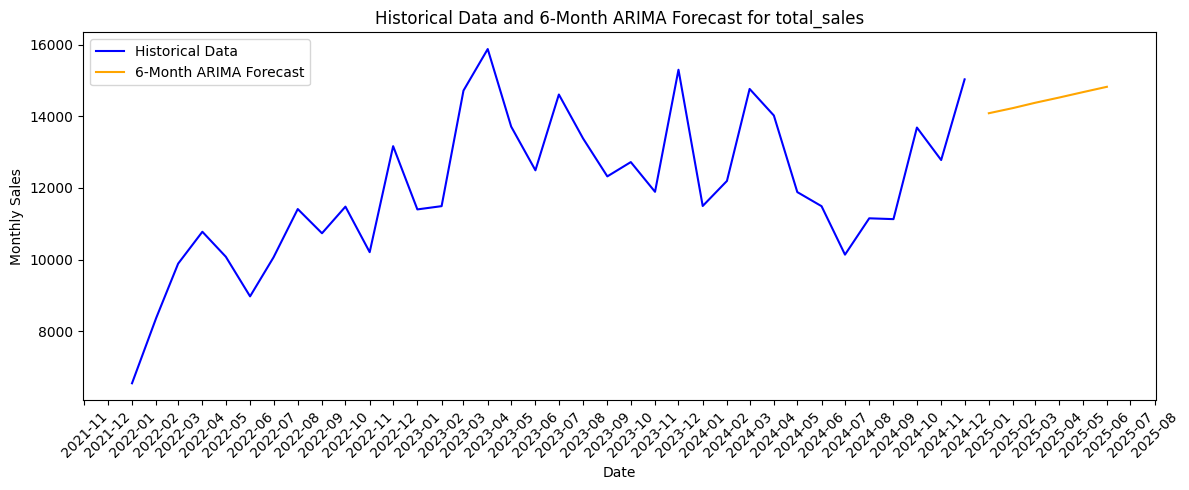


=== Plotting ARIMA Forecast for: cone_without_topping ===


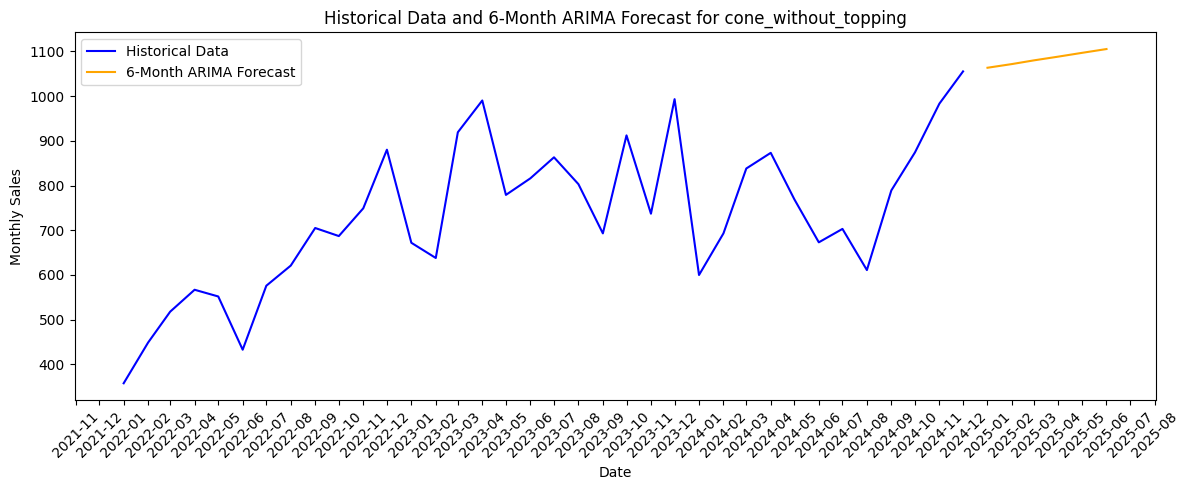


=== Plotting ARIMA Forecast for: simple_freddo ===


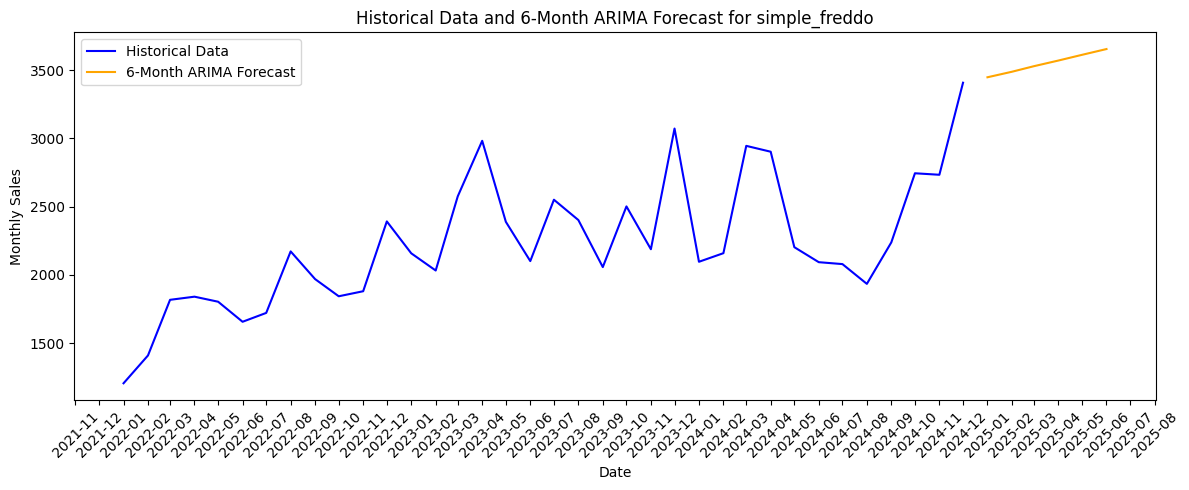


=== Plotting ARIMA Forecast for: simple_tulip ===


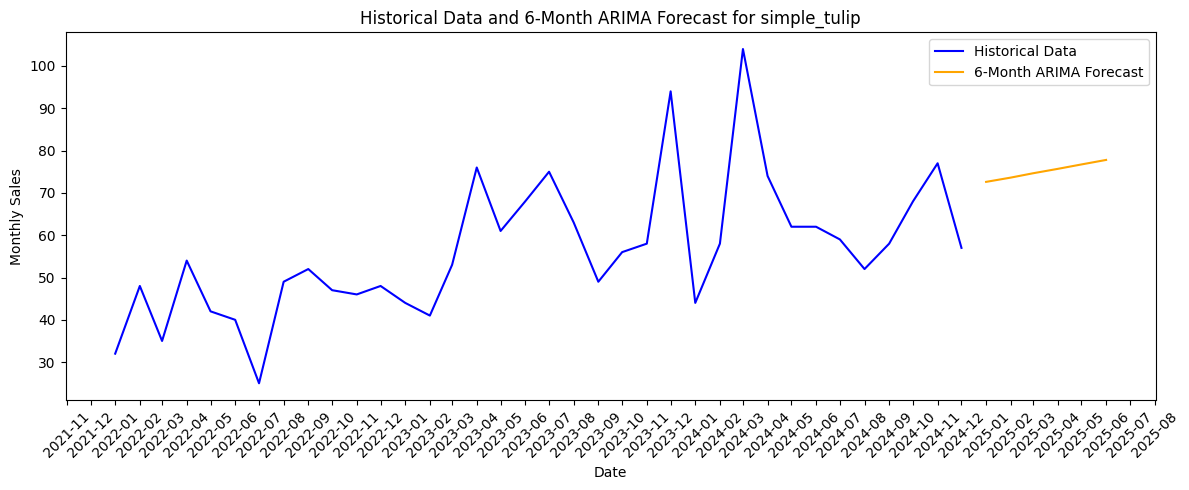

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Loop to plot a separate forecast graph for each variable
for col in numeric_columns:

    print(f"\n=== Plotting ARIMA Forecast for: {col} ===")

    plt.figure(figsize=(12, 5))

    # 1. Historical data (full series)
    plt.plot(df_mensual.index, df_mensual[col], label="Historical Data", color="blue")

    # 2. Forecast (6 months starting 2025-01)
    plt.plot(forecast_6m[col].index, forecast_6m[col], 
             label="6-Month ARIMA Forecast", color="orange")

    # ===== FORMAT X AXIS (show all months) =====
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())           
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    # Labels and title
    plt.title(f"Historical Data and 6-Month ARIMA Forecast for {col}")
    plt.xlabel("Date")
    plt.ylabel("Monthly Sales")
    plt.legend()
    plt.tight_layout()
    plt.show()


## SARIMA MODEL

El código extrae e imprime los parámetros óptimos de cada modelo SARIMA generado por auto_arima, permitiendo documentar y reproducir el modelo seleccionado para cada serie temporal. Además, sirve como base para entrenar, evaluar y comparar los modelos posteriores, como ARIMA vs SARIMA.

In [26]:
from pmdarima import auto_arima

# Dictionary to store SARIMA models
sarima_models = {}

for col in numeric_columns:

    print(f"\n===============================")
    print(f" AUTO-SARIMA for variable: {col}")
    print(f"===============================")

    y = df_mensual[col]

    modelo_season = auto_arima(
        y,
        seasonal=True,
        m=12,                # monthly seasonality
        d=0,                 # stationary (ADF said no differencing)
        max_D=1,             # test only D = 0 or 1
        start_p=0, max_p=2,
        start_q=0, max_q=2,
        start_P=0, max_P=2,
        start_Q=0, max_Q=2,
        trace=True,
        error_action="ignore",
        suppress_warnings=True,
        stepwise=True
    )

    sarima_models[col] = modelo_season

    print("\nBest SARIMA model:")
    print(modelo_season.summary())



 AUTO-SARIMA for variable: total_sales
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=447.336, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=424.516, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=424.778, Time=0.74 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=450.167, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=423.829, Time=0.07 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=423.412, Time=0.22 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=423.353, Time=0.36 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=425.349, Time=0.87 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(2,0,0)(0,1,2)[12] intercept   : AIC=425.403, Time=0.45 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=425.173, Time=0.70 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=424.431, Time=0.85 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=424.180, Time=1.55 sec
 

In [27]:
print("\n===== SARIMA PARAMETERS FOR EACH VARIABLE =====\n")

for col in sarima_models.keys():
    model = sarima_models[col]

    print(f"Variable: {col}")
    print(f"  ARIMA Order (p,d,q):           {model.order}")
    print(f"  Seasonal Order (P,D,Q,s):      {model.seasonal_order}")
    print("-" * 60)



===== SARIMA PARAMETERS FOR EACH VARIABLE =====

Variable: total_sales
  ARIMA Order (p,d,q):           (1, 0, 0)
  Seasonal Order (P,D,Q,s):      (0, 1, 1, 12)
------------------------------------------------------------
Variable: cone_without_topping
  ARIMA Order (p,d,q):           (1, 0, 0)
  Seasonal Order (P,D,Q,s):      (1, 1, 0, 12)
------------------------------------------------------------
Variable: simple_freddo
  ARIMA Order (p,d,q):           (1, 0, 1)
  Seasonal Order (P,D,Q,s):      (0, 1, 0, 12)
------------------------------------------------------------
Variable: simple_tulip
  ARIMA Order (p,d,q):           (1, 0, 1)
  Seasonal Order (P,D,Q,s):      (0, 0, 0, 12)
------------------------------------------------------------


In [28]:
sarima_params = {
    "total_sales": {
        "order": (1, 0, 0),
        "seasonal_order": (0, 1, 1, 12)
    },
    "cone_without_topping": {
        "order": (1, 0, 0),
        "seasonal_order": (1, 1, 0, 12)
    },
    "simple_freddo": {
        "order": (1, 0, 1),
        "seasonal_order": (0, 1, 1, 12)
    },
    "simple_tulip": {
        "order": (1, 0, 1),
        "seasonal_order": (0, 0, 0, 12)
    }
}


In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Dictionary to store the fitted SARIMA models
sarima_fitted = {}

print("\n===== FITTING SARIMA MODELS FOR EACH VARIABLE =====\n")

for col in numeric_columns:

    print(f"Fitting SARIMA for variable: {col}")

    p, d, q = sarima_params[col]["order"]
    P, D, Q, s = sarima_params[col]["seasonal_order"]

    # Fit SARIMA model using TRAIN data
    model = SARIMAX(
        train_series[col],
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    fitted_model = model.fit()

    # Store fitted model
    sarima_fitted[col] = fitted_model

    print(f"Model fitted: SARIMA{(p,d,q)}x{(P,D,Q,s)}")
    print("-" * 70)



===== FITTING SARIMA MODELS FOR EACH VARIABLE =====

Fitting SARIMA for variable: total_sales
Model fitted: SARIMA(1, 0, 0)x(0, 1, 1, 12)
----------------------------------------------------------------------
Fitting SARIMA for variable: cone_without_topping


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will b

Model fitted: SARIMA(1, 0, 0)x(1, 1, 0, 12)
----------------------------------------------------------------------
Fitting SARIMA for variable: simple_freddo


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Model fitted: SARIMA(1, 0, 1)x(0, 1, 1, 12)
----------------------------------------------------------------------
Fitting SARIMA for variable: simple_tulip
Model fitted: SARIMA(1, 0, 1)x(0, 0, 0, 12)
----------------------------------------------------------------------


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [30]:
print("\n===== SARIMA MODEL SUMMARIES FOR EACH VARIABLE =====\n")

for col in sarima_fitted.keys():
    print(f"\n====== Summary for variable: {col} ======\n")
    print(sarima_fitted[col].summary())
    print("\n" + "="*80 + "\n")



===== SARIMA MODEL SUMMARIES FOR EACH VARIABLE =====


====== Summary for variable: total_sales ======

                                      SARIMAX Results                                       
Dep. Variable:                          total_sales   No. Observations:                   28
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 -24.556
Date:                              Wed, 03 Dec 2025   AIC                             55.113
Time:                                      19:38:36   BIC                             52.409
Sample:                                  01-01-2022   HQIC                            49.677
                                       - 04-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3160: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3160: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3160: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemode

#### Test de Ljung–Box

Para evaluar la validez de los modelos SARIMA ajustados, se aplicó el test de Ljung–Box a los residuos utilizando rezagos 10, 15 y 20. Este test permite verificar si los residuos presentan autocorrelación significativa; por tanto, un p-valor mayor a 0.05 indica que los residuos se comportan como ruido blanco y que el modelo captura adecuadamente la estructura temporal de la serie.

Los resultados muestran que:

total_sales presenta p-valores inferiores a 0.05 en algunos rezagos, lo que evidencia autocorrelación residual. Este hallazgo sugiere que el modelo SARIMA seleccionado no logra capturar completamente la dinámica de la serie y podría beneficiarse de ajustes adicionales o una modelación alternativa.

En contraste, las series cone_without_topping, simple_freddo y simple_tulip exhiben p-valores superiores a 0.05 en todos los rezagos evaluados. Esto indica que sus residuos no presentan autocorrelación estadísticamente significativa, cumpliendo el supuesto de ruido blanco. Por lo tanto, los modelos SARIMA ajustados para estas variables pueden considerarse adecuados en términos del comportamiento de los residuos.

Desde una perspectiva gráfica, los residuos de las variables correctamente ajustadas oscilarían de manera aleatoria alrededor de cero sin patrones visibles, mientras que la serie que falla (total_sales) tendería a mostrar patrones repetitivos o correlación entre rezagos, consistente con los valores del test.


In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd

print("\n===== LJUNG-BOX TEST FOR SARIMA RESIDUALS (All Variables) =====\n")

ljungbox_results = {}

for col in sarima_fitted.keys():

    print(f"\n=== Ljung-Box test for variable: {col} ===")

    # Get SARIMA residuals
    resid = sarima_fitted[col].resid.dropna()

    # Ljung-Box test at lags 10, 15, 20
    lb = acorr_ljungbox(
        resid,
        lags=[10, 15, 20],
        return_df=True
    )

    ljungbox_results[col] = lb

    print(lb)
    print("-" * 70)



===== LJUNG-BOX TEST FOR SARIMA RESIDUALS (All Variables) =====


=== Ljung-Box test for variable: total_sales ===
      lb_stat  lb_pvalue
10  20.326354   0.026313
15  23.695889   0.070441
20  42.646750   0.002276
----------------------------------------------------------------------

=== Ljung-Box test for variable: cone_without_topping ===
      lb_stat  lb_pvalue
10   5.726532   0.837692
15   6.281571   0.974620
20  10.425749   0.959779
----------------------------------------------------------------------

=== Ljung-Box test for variable: simple_freddo ===
      lb_stat  lb_pvalue
10  11.311206   0.333792
15  12.954059   0.605846
20  22.779439   0.299754
----------------------------------------------------------------------

=== Ljung-Box test for variable: simple_tulip ===
      lb_stat  lb_pvalue
10   9.337599   0.500392
15  14.792192   0.466487
20  19.479939   0.490855
----------------------------------------------------------------------


#### RESIDUAL DIAGNOSTICS FOR ALL SARIMA MODELS 


===== RESIDUAL DIAGNOSTICS FOR ALL SARIMA MODELS =====


=== Diagnostic plots for variable: total_sales ===


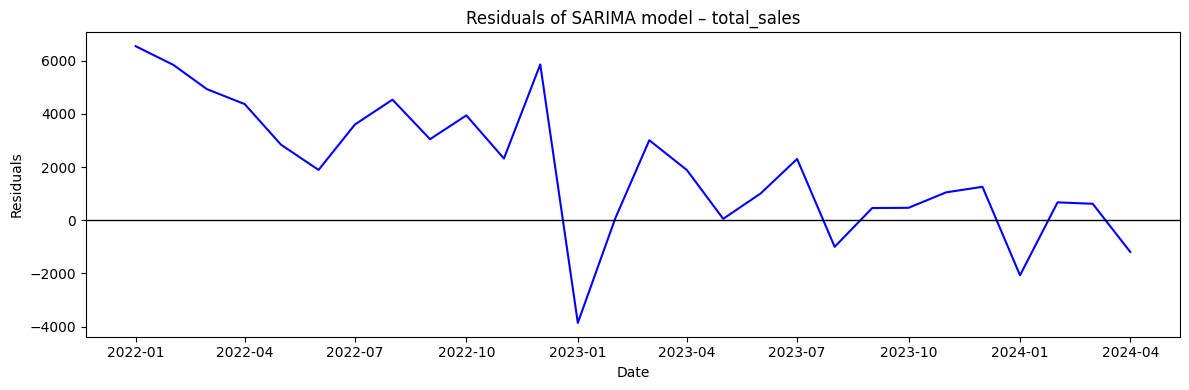

<Figure size 1200x400 with 0 Axes>

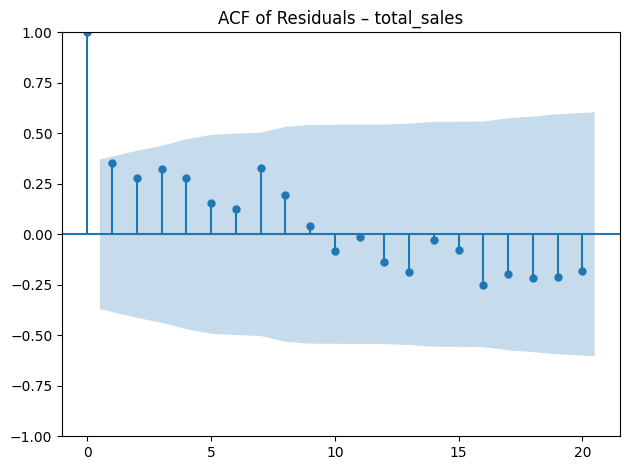


=== Diagnostic plots for variable: cone_without_topping ===


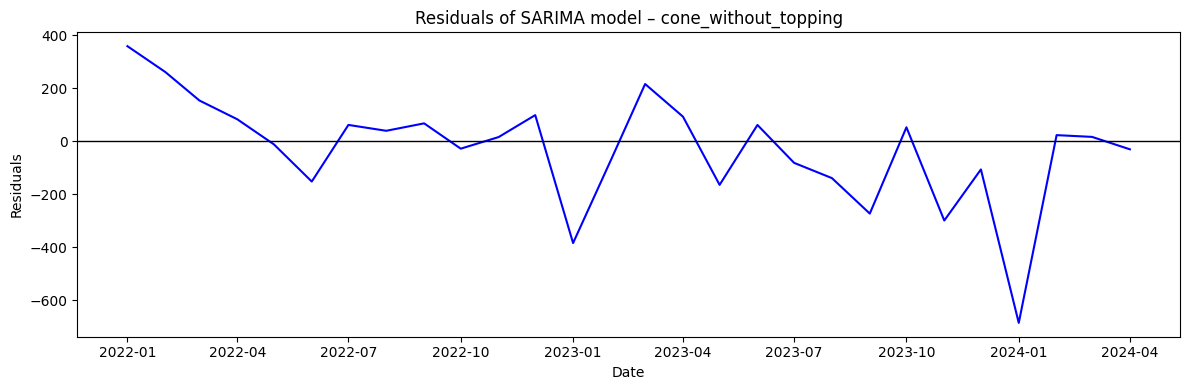

<Figure size 1200x400 with 0 Axes>

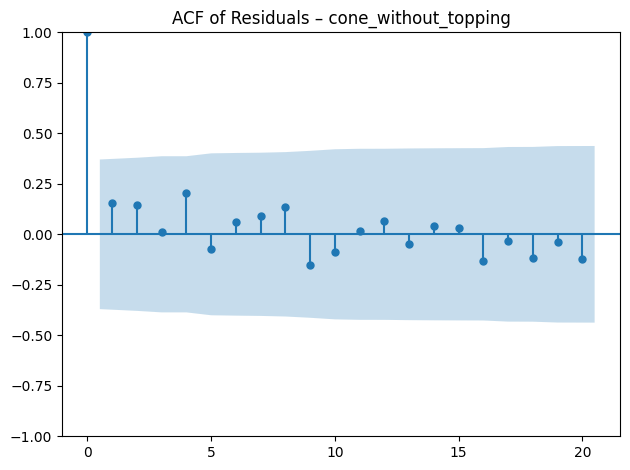


=== Diagnostic plots for variable: simple_freddo ===


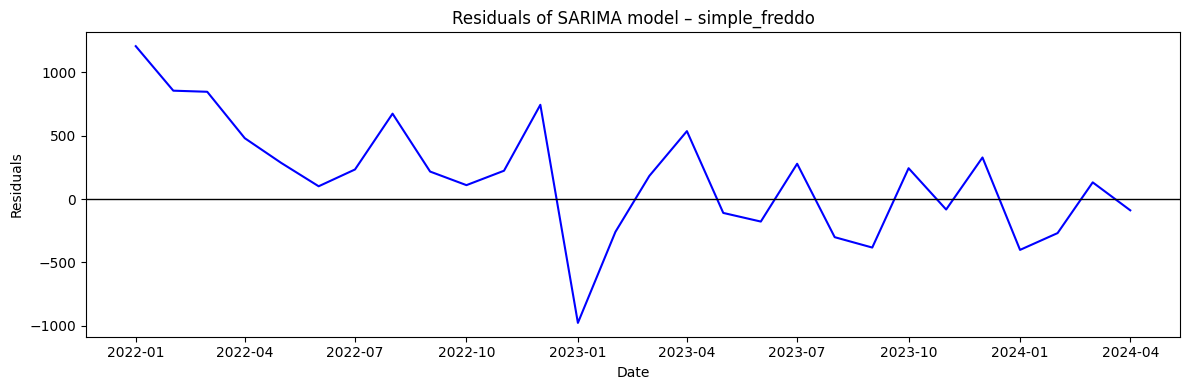

<Figure size 1200x400 with 0 Axes>

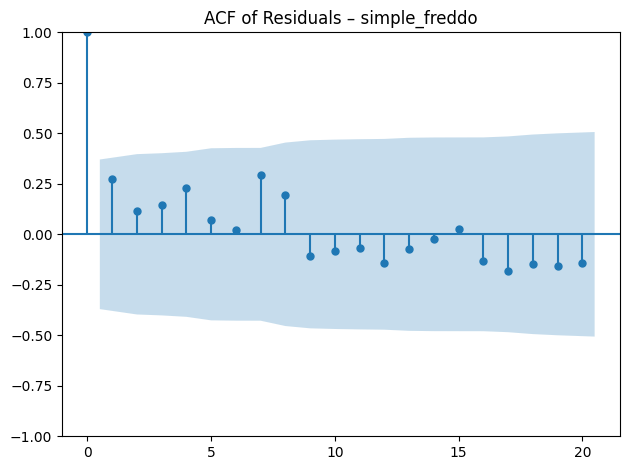


=== Diagnostic plots for variable: simple_tulip ===


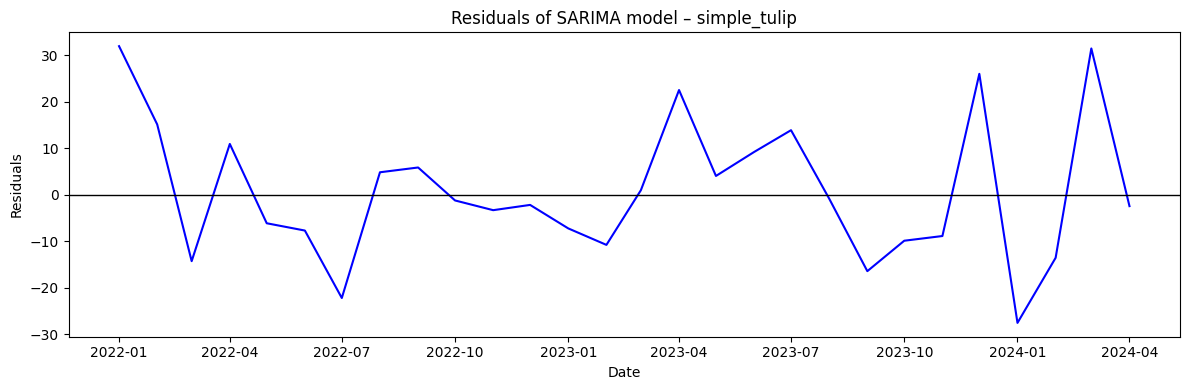

<Figure size 1200x400 with 0 Axes>

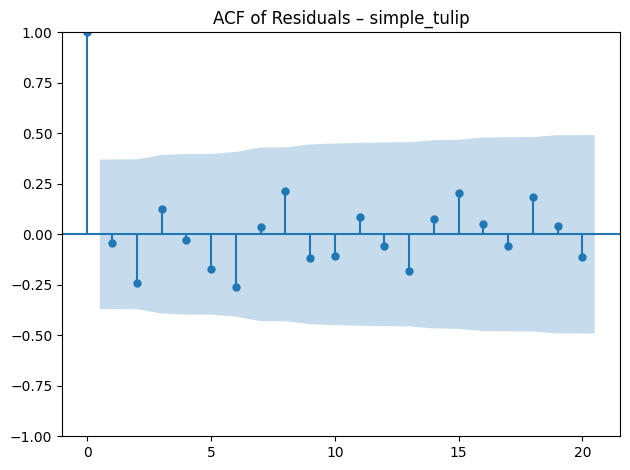

In [32]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

print("\n===== RESIDUAL DIAGNOSTICS FOR ALL SARIMA MODELS =====\n")

for col in sarima_fitted.keys():

    print(f"\n=== Diagnostic plots for variable: {col} ===")

    # Get residuals
    resid = sarima_fitted[col].resid.dropna()

    # -------------------------------
    # 1. Residual Time Series Plot
    # -------------------------------
    plt.figure(figsize=(12,4))
    plt.plot(resid, label="Residuals", color="blue")
    plt.axhline(0, color="black", linewidth=1)
    plt.title(f"Residuals of SARIMA model – {col}")
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # 2. ACF of Residuals
    # -------------------------------
    plt.figure(figsize=(12,4))
    plot_acf(resid, lags=20)
    plt.title(f"ACF of Residuals – {col}")
    plt.tight_layout()
    plt.show()


1. total_sales

El gráfico de residuos del modelo SARIMA aplicado a la serie total_sales evidencia fluctuaciones pronunciadas y patrones visibles alrededor de cero, lo que indica que los residuos no se comportan de forma completamente aleatoria. Esta observación se refuerza en la función de autocorrelación (ACF), donde múltiples rezagos exceden las bandas de significancia. Dicho comportamiento sugiere la presencia de autocorrelación residual, lo cual indica que el modelo no captura adecuadamente la estructura temporal de la serie.
En conjunto con los resultados del test de Ljung–Box, estos hallazgos apuntan a una especificación insuficiente del modelo, requiriendo posiblemente mayor complejidad estacional o no estacional, o la consideración de modelos alternativos.

2. cone_without_topping

En el caso de cone_without_topping, los residuos muestran oscilaciones alrededor de cero sin patrones sistemáticos ni rachas prolongadas, lo que sugiere un comportamiento cercano al de ruido blanco. La ACF de los residuos respalda esta conclusión, ya que la mayoría de las autocorrelaciones se encuentran dentro de las bandas de significancia.
No se observan indicios de autocorrelación residual relevante, lo cual confirma que el modelo SARIMA seleccionado captura de manera adecuada la dinámica temporal de esta serie. Este resultado es coherente con los p-valores altos del test de Ljung–Box.

3. simple_freddo

Los residuos del modelo SARIMA para simple_freddo se distribuyen alrededor de cero sin tendencias aparentes o patrones persistentes. La ACF muestra valores dentro de los límites de significancia para la mayoría de los rezagos, sin evidencia de correlaciones sistemáticas.
Este comportamiento es indicativo de residuos compatibles con ruido blanco, sugiriendo que el modelo SARIMA ajustado es apropiado para esta serie. Además, los resultados del Ljung–Box corroboran la ausencia de autocorrelación residual significativa.

4. simple_tulip

El análisis de la serie de residuos para simple_tulip muestra fluctuaciones moderadas alrededor de cero, sin estructuras repetitivas o patrones deterministas. La ACF revela autocorrelaciones dentro de los intervalos de confianza, lo que indica la ausencia de correlación significativa entre los residuos.
Estos resultados son consistentes con un modelo bien especificado, donde los residuos actúan como ruido blanco. La validez del modelo se ve reforzada por los p-valores del test de Ljung–Box, que no rechazan la hipótesis nula de no autocorrelación.


===== SARIMA FORECAST PLOTS FOR ALL VARIABLES =====

Generating plot for: total_sales


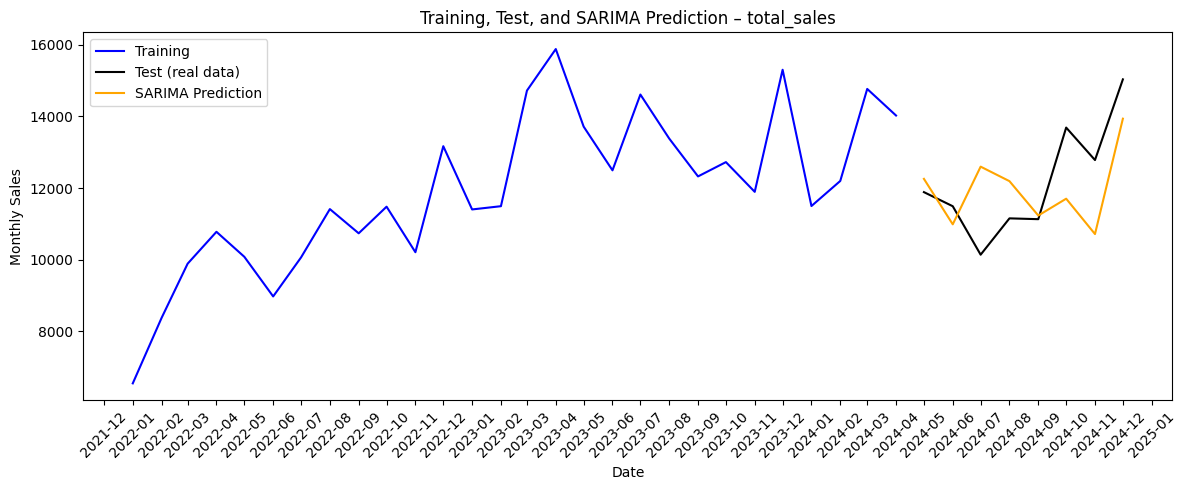

Generating plot for: cone_without_topping


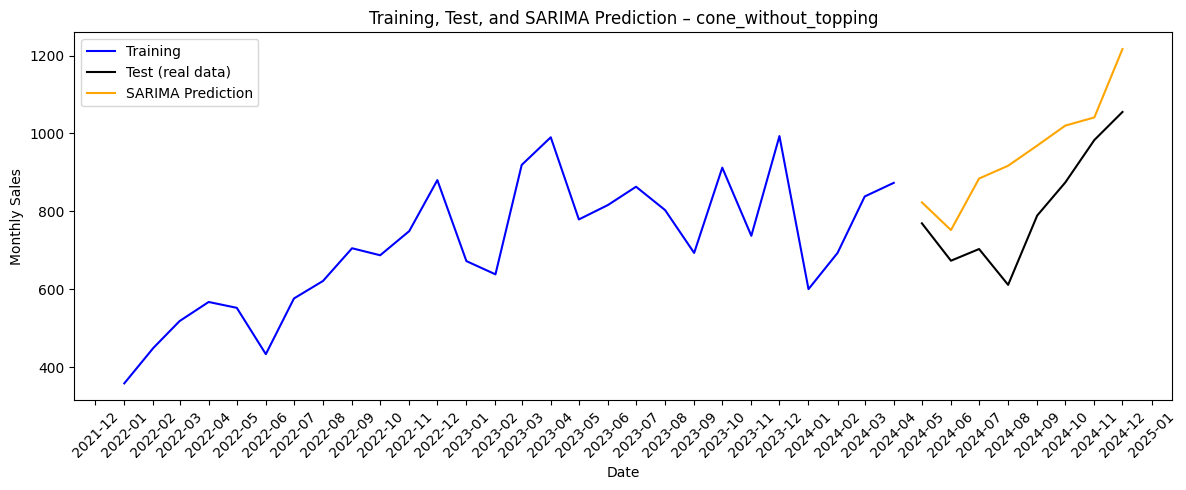

Generating plot for: simple_freddo


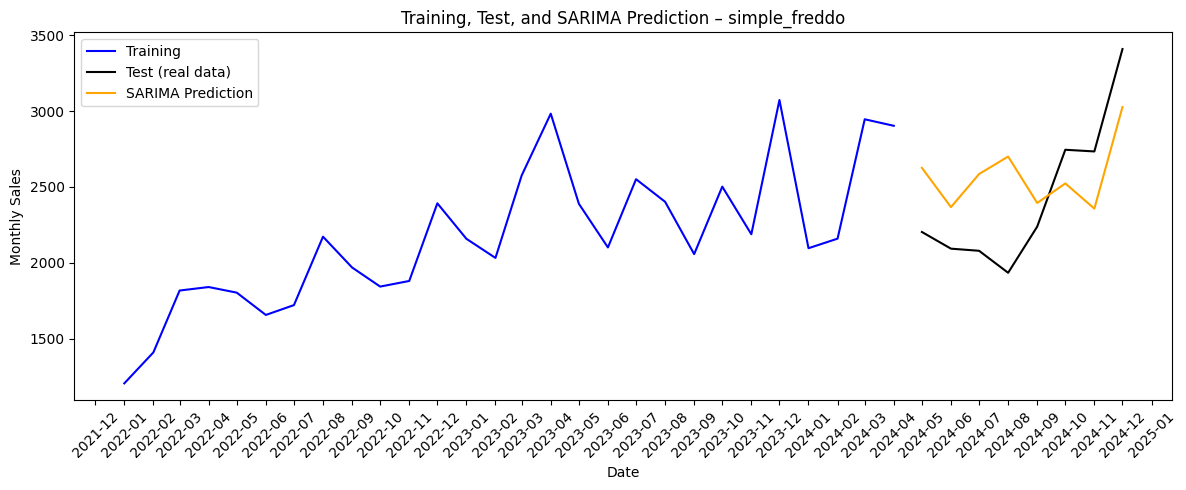

Generating plot for: simple_tulip


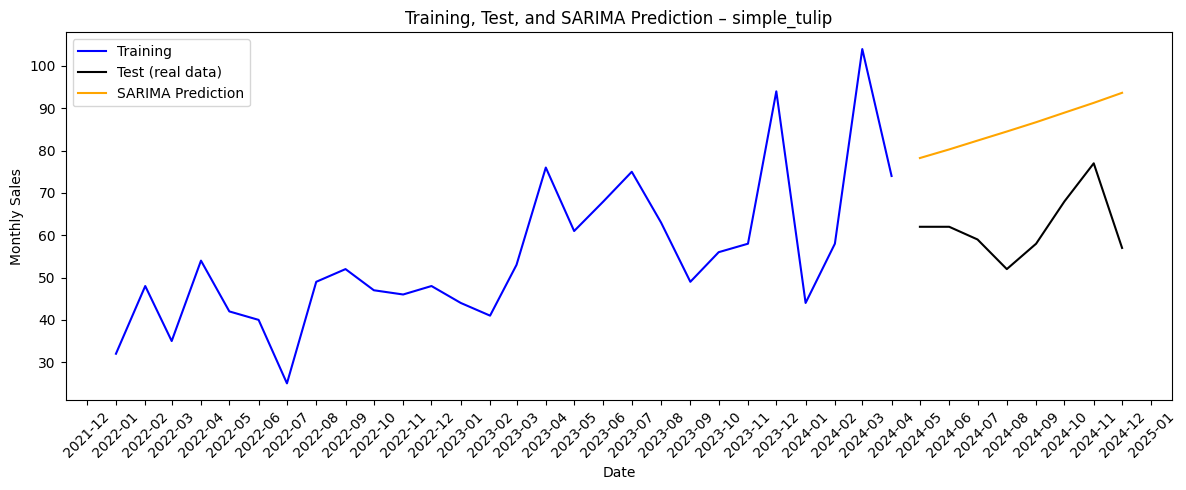

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

print("\n===== SARIMA FORECAST PLOTS FOR ALL VARIABLES =====\n")

for col in numeric_columns:

    print(f"Generating plot for: {col}")

    # === 1. Get the fitted SARIMA model for this variable ===
    model = sarima_fitted[col]

    # === 2. Number of months in test ===
    n_test = len(test_series[col])

    # === 3. Forecast aligned to test dates (no gaps) ===
    pred_sarima = pd.Series(
        model.forecast(steps=n_test),
        index=test_series[col].index
    )

    # === 4. Plot ===
    plt.figure(figsize=(12,5))

    # Training series
    plt.plot(train_series[col].index, train_series[col],
             label="Training", color="blue")

    # Test series
    plt.plot(test_series[col].index, test_series[col],
             label="Test (real data)", color="black")

    # SARIMA prediction
    plt.plot(pred_sarima.index, pred_sarima,
             label="SARIMA Prediction", color="orange")

    # === X-AXIS: show EVERY MONTH ===
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())           
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    # Labels and title
    plt.title(f"Training, Test, and SARIMA Prediction – {col}")
    plt.xlabel("Date")
    plt.ylabel("Monthly Sales")
    plt.legend()
    plt.tight_layout()
    plt.show()


#### PREDICTION SARIMA 6 MONTHS

In [34]:
import pandas as pd

sarima_fitted_full = {}

for col in numeric_columns:
    p, d, q = sarima_params[col]["order"]
    P, D, Q, s = sarima_params[col]["seasonal_order"]

    model = SARIMAX(
        df_mensual[col],     # <-- FULL SERIES
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    sarima_fitted_full[col] = model.fit()
   # print(f"Fitted full SARIMA for {col}")
 
future_2025 = pd.date_range(start="2025-01-01", periods=6, freq="MS")
sarima_forecast_2025 = {}

for col in numeric_columns:

    print(f"\n=== 2025 Forecast for: {col} ===")

    model = sarima_fitted_full[col]

    forecast_values = pd.Series(
        model.forecast(steps=6),
        index=future_2025
    )

    sarima_forecast_2025[col] = forecast_values
    print(forecast_values)


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will b


=== 2025 Forecast for: total_sales ===
2025-01-01    11709.589552
2025-02-01    11970.817971
2025-03-01    14373.294349
2025-04-01    14081.314063
2025-05-01    12020.550265
2025-06-01    11364.936109
Freq: MS, Name: predicted_mean, dtype: float64

=== 2025 Forecast for: cone_without_topping ===
2025-01-01     800.775983
2025-02-01     772.723022
2025-03-01    1018.638423
2025-04-01    1072.092450
2025-05-01     867.900465
2025-06-01     873.971980
Freq: MS, Name: predicted_mean, dtype: float64

=== 2025 Forecast for: simple_freddo ===
2025-01-01    2328.166522
2025-02-01    2203.464934
2025-03-01    2829.670508
2025-04-01    2854.714461
2025-05-01    2215.990152
2025-06-01    2060.031015
Freq: MS, Name: predicted_mean, dtype: float64

=== 2025 Forecast for: simple_tulip ===
2025-01-01    72.604535
2025-02-01    73.613308
2025-03-01    74.636097
2025-04-01    75.673097
2025-05-01    76.724506
2025-06-01    77.790522
Freq: MS, Name: predicted_mean, dtype: float64


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



===== SARIMA 2025 FORECAST VISUALIZATION (ALL VARIABLES) =====

Plotting forecast for: total_sales


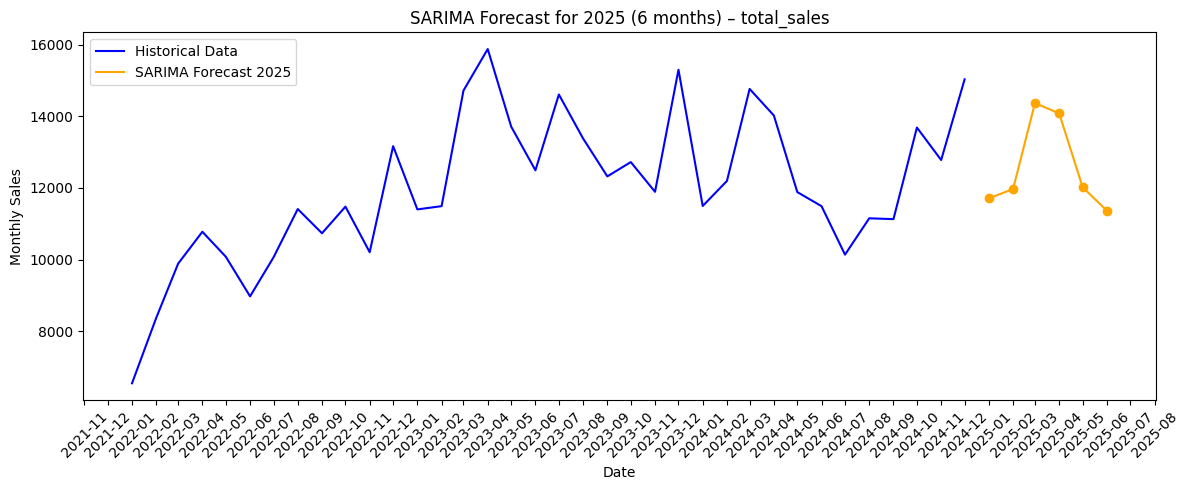

Plotting forecast for: cone_without_topping


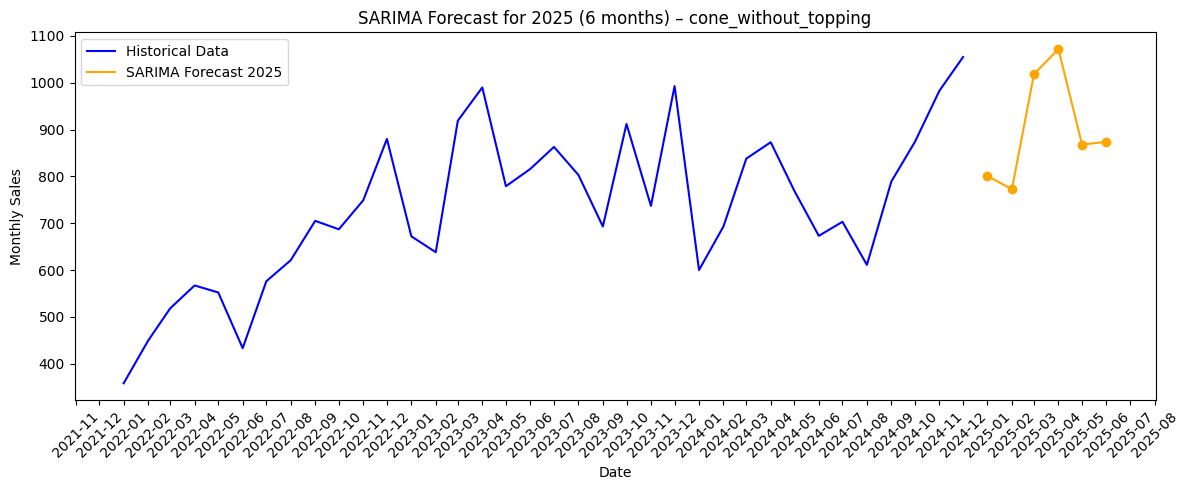

Plotting forecast for: simple_freddo


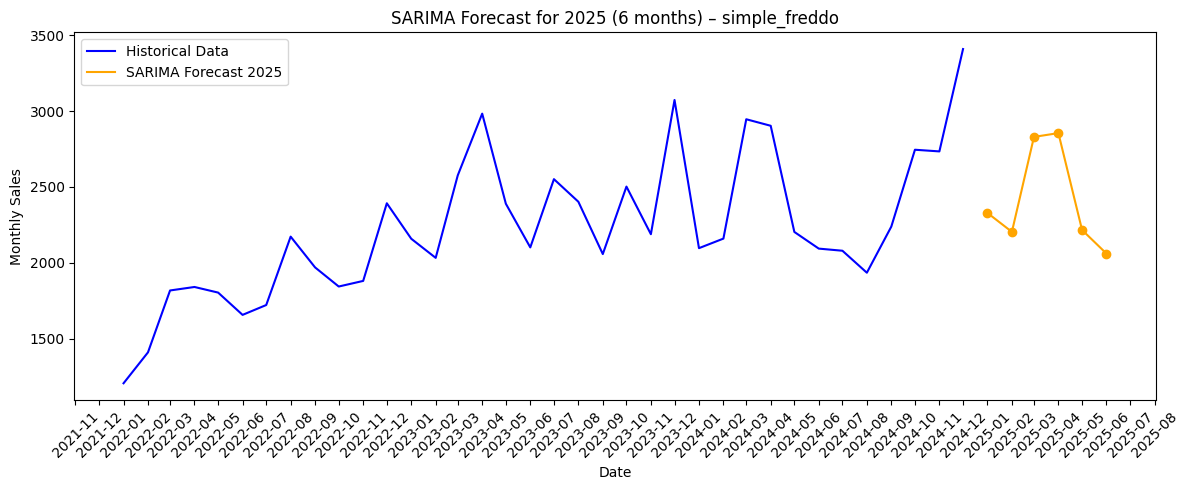

Plotting forecast for: simple_tulip


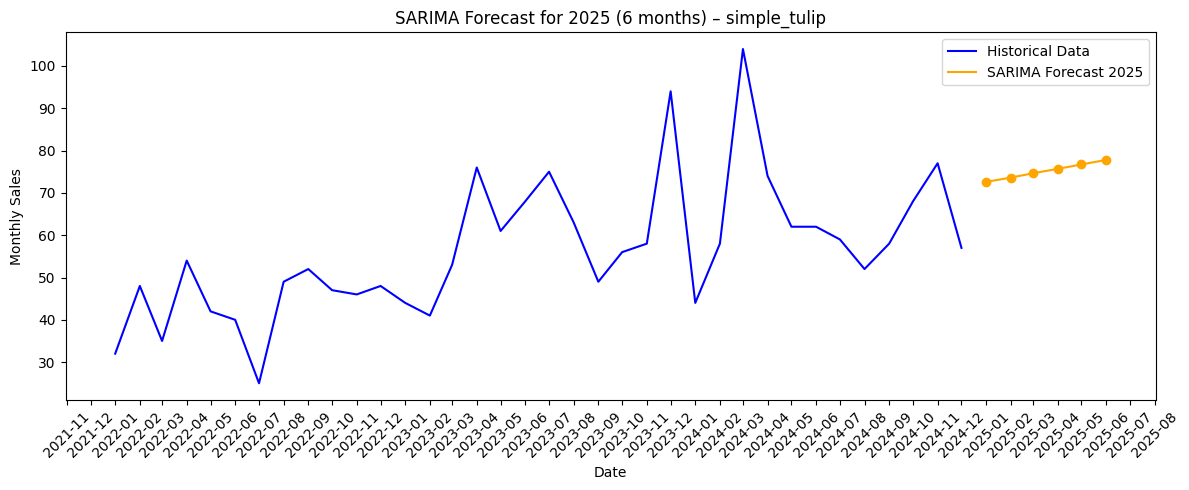

In [35]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("\n===== SARIMA 2025 FORECAST VISUALIZATION (ALL VARIABLES) =====\n")

for col in numeric_columns:

    print(f"Plotting forecast for: {col}")

    # Historical data
    full_series = df_mensual[col]

    # 6-month forecast (2025)
    forecast_2025 = sarima_forecast_2025[col]

    plt.figure(figsize=(12,5))

    # Plot historical series
    plt.plot(full_series.index, full_series,
             label="Historical Data", color="blue")

    # Plot forecast 2025
    plt.plot(forecast_2025.index, forecast_2025,
             label="SARIMA Forecast 2025", color="orange")

    # Mark forecast points clearly
    plt.scatter(forecast_2025.index, forecast_2025, color="orange")

    # X-axis: show every month
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    # Labels and title
    plt.title(f"SARIMA Forecast for 2025 (6 months) – {col}")
    plt.xlabel("Date")
    plt.ylabel("Monthly Sales")
    plt.legend()
    plt.tight_layout()
    plt.show()


#### METRICS ARIMA VS SARIMA


In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Dictionary to store ARIMA metrics
metrics_arima = {}

for col in numeric_columns:

    print(f"\n=== ARIMA Metrics for: {col} ===")

    # Real test values
    y_true = test_series[col]

    # ARIMA model
    model = SARIMAX(
        train_series[col],
        order=arima_orders[col],
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit()

    n_test = len(test_series[col])

    pred = pd.Series(
        model.forecast(steps=n_test),
        index=test_series[col].index
    )

    # ----- Metrics -----
    arima_rmse = np.sqrt(mean_squared_error(y_true, pred))
    arima_mae  = mean_absolute_error(y_true, pred)
    arima_mape = np.mean(np.abs((y_true - pred) / y_true)) * 100

    # Store metrics with CLEAR ARIMA labels
    metrics_arima[col] = {
        "ARIMA_RMSE": arima_rmse,
        "ARIMA_MAE": arima_mae,
        "ARIMA_MAPE": arima_mape
    }

    print(f"ARIMA RMSE: {arima_rmse:.4f}")
    print(f"ARIMA MAE:  {arima_mae:.4f}")
    print(f"ARIMA MAPE: {arima_mape:.2f}%")



=== ARIMA Metrics for: total_sales ===
ARIMA RMSE: 3010.7570
ARIMA MAE:  2773.3231
ARIMA MAPE: 24.21%

=== ARIMA Metrics for: cone_without_topping ===
ARIMA RMSE: 158.6320
ARIMA MAE:  139.6032
ARIMA MAPE: 18.82%

=== ARIMA Metrics for: simple_freddo ===
ARIMA RMSE: 721.2158
ARIMA MAE:  663.7785
ARIMA MAPE: 30.13%

=== ARIMA Metrics for: simple_tulip ===


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\P

ARIMA RMSE: 25.0338
ARIMA MAE:  23.8796
ARIMA MAPE: 40.13%


In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Dictionary to store SARIMA metrics
metrics_sarima = {}

print("\n===== SARIMA METRICS (RMSE, MAE, MAPE) FOR EACH VARIABLE =====\n")

for col in numeric_columns:

    print(f"\n=== SARIMA Metrics for: {col} ===")

    # Real values of the test set
    y_true = test_series[col]

    # SARIMA model fitted with TRAIN data
    model = sarima_fitted[col]

    # Number of months in test
    n_test = len(test_series[col])

    # Forecast aligned to test index
    pred_sarima = pd.Series(
        model.forecast(steps=n_test),
        index=test_series[col].index
    )

    # ----- Metrics -----
    rmse = np.sqrt(mean_squared_error(y_true, pred_sarima))
    mae  = mean_absolute_error(y_true, pred_sarima)
    mape = np.mean(np.abs((y_true - pred_sarima) / y_true)) * 100

    # Store with SARIMA labels
    metrics_sarima[col] = {
        "SARIMA_RMSE": rmse,
        "SARIMA_MAE": mae,
        "SARIMA_MAPE": mape
    }

    print(f"SARIMA RMSE: {rmse:.4f}")
    print(f"SARIMA MAE:  {mae:.4f}")
    print(f"SARIMA MAPE: {mape:.2f}%")



===== SARIMA METRICS (RMSE, MAE, MAPE) FOR EACH VARIABLE =====


=== SARIMA Metrics for: total_sales ===
SARIMA RMSE: 1455.4281
SARIMA MAE:  1203.1707
SARIMA MAPE: 10.00%

=== SARIMA Metrics for: cone_without_topping ===
SARIMA RMSE: 165.2701
SARIMA MAE:  145.5827
SARIMA MAPE: 19.40%

=== SARIMA Metrics for: simple_freddo ===
SARIMA RMSE: 427.0122
SARIMA MAE:  388.2750
SARIMA MAPE: 17.04%

=== SARIMA Metrics for: simple_tulip ===
SARIMA RMSE: 25.0338
SARIMA MAE:  23.8796
SARIMA MAPE: 40.13%


#### WORKING (0,0,1)(0,0,1) A. Azzahra and I. D. Sudirman

#### SARIMA

In [38]:
import pandas as pd

sarima_fitted_full = {}

for col in numeric_columns:
    p, d, q = (0,0,1)
    P, D, Q, s = (0,0,1,12)

    model = SARIMAX(
        df_mensual[col],     # <-- FULL SERIES
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    sarima_fitted_full[col] = model.fit()
   # print(f"Fitted full SARIMA for {col}")
 
future_2025 = pd.date_range(start="2025-01-01", periods=6, freq="MS")
sarima_forecast_2025 = {}

for col in numeric_columns:

    print(f"\n=== 2025 Forecast for: {col} ===")

    model = sarima_fitted_full[col]

    forecast_values = pd.Series(
        model.forecast(steps=6),
        index=future_2025
    )

    sarima_forecast_2025[col] = forecast_values
    print(forecast_values)


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will b


=== 2025 Forecast for: total_sales ===
2025-01-01    8049.268307
2025-02-01    5798.355098
2025-03-01    8495.901283
2025-04-01    6299.747856
2025-05-01    6493.447410
2025-06-01    5729.728202
Freq: MS, Name: predicted_mean, dtype: float64

=== 2025 Forecast for: cone_without_topping ===
2025-01-01    408.203124
2025-02-01    305.196799
2025-03-01    273.479994
2025-04-01    271.437940
2025-05-01    273.057752
2025-06-01    193.339423
Freq: MS, Name: predicted_mean, dtype: float64

=== 2025 Forecast for: simple_freddo ===
2025-01-01    1574.784846
2025-02-01     898.601550
2025-03-01    1602.375972
2025-04-01    1335.371479
2025-05-01    1080.742400
2025-06-01    1089.691180
Freq: MS, Name: predicted_mean, dtype: float64

=== 2025 Forecast for: simple_tulip ===
2025-01-01     8.394197
2025-02-01    36.893269
2025-03-01    51.695060
2025-04-01    24.019895
2025-05-01    21.015470
2025-06-01    18.675066
Freq: MS, Name: predicted_mean, dtype: float64


In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Dictionary to store SARIMA metrics
metrics_sarima = {}

print("\n===== SARIMA METRICS (RMSE, MAE, MAPE) FOR EACH VARIABLE =====\n")

for col in numeric_columns:

    print(f"\n=== SARIMA Metrics for: {col} ===")

    # Real values of the test set
    y_true = test_series[col]

    # SARIMA model fitted with TRAIN data
    model = sarima_fitted[col]

    # Number of months in test
    n_test = len(test_series[col])

    # Forecast aligned to test index
    pred_sarima = pd.Series(
        model.forecast(steps=n_test),
        index=test_series[col].index
    )

    # ----- Metrics -----
    rmse = np.sqrt(mean_squared_error(y_true, pred_sarima))
    mae  = mean_absolute_error(y_true, pred_sarima)
    mape = np.mean(np.abs((y_true - pred_sarima) / y_true)) * 100

    # Store with SARIMA labels
    metrics_sarima[col] = {
        "SARIMA_RMSE": rmse,
        "SARIMA_MAE": mae,
        "SARIMA_MAPE": mape
    }

    print(f"SARIMA RMSE: {rmse:.4f}")
    print(f"SARIMA MAE:  {mae:.4f}")
    print(f"SARIMA MAPE: {mape:.2f}%")



===== SARIMA METRICS (RMSE, MAE, MAPE) FOR EACH VARIABLE =====


=== SARIMA Metrics for: total_sales ===
SARIMA RMSE: 1455.4281
SARIMA MAE:  1203.1707
SARIMA MAPE: 10.00%

=== SARIMA Metrics for: cone_without_topping ===
SARIMA RMSE: 165.2701
SARIMA MAE:  145.5827
SARIMA MAPE: 19.40%

=== SARIMA Metrics for: simple_freddo ===
SARIMA RMSE: 427.0122
SARIMA MAE:  388.2750
SARIMA MAPE: 17.04%

=== SARIMA Metrics for: simple_tulip ===
SARIMA RMSE: 25.0338
SARIMA MAE:  23.8796
SARIMA MAPE: 40.13%


#### ARIMA

In [40]:
import pandas as pd

sarima_fitted_full = {}

for col in numeric_columns:
    p, d, q = (0,0,1)
    P, D, Q, s = (0,0,0,0)

    model = SARIMAX(
        df_mensual[col],     # <-- FULL SERIES
        order=(0, 0, 1),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    sarima_fitted_full[col] = model.fit()
   # print(f"Fitted full SARIMA for {col}")
 
future_2025 = pd.date_range(start="2025-01-01", periods=6, freq="MS")
sarima_forecast_2025 = {}

for col in numeric_columns:

    print(f"\n=== 2025 Forecast for: {col} ===")

    model = sarima_fitted_full[col]

    forecast_values = pd.Series(
        model.forecast(steps=6),
        index=future_2025
    )

    sarima_forecast_2025[col] = forecast_values
    print(forecast_values)


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\P


=== 2025 Forecast for: total_sales ===
2025-01-01    9808.270384
2025-02-01       0.000000
2025-03-01       0.000000
2025-04-01       0.000000
2025-05-01       0.000000
2025-06-01       0.000000
Freq: MS, Name: predicted_mean, dtype: float64

=== 2025 Forecast for: cone_without_topping ===
2025-01-01    481.375429
2025-02-01      0.000000
2025-03-01      0.000000
2025-04-01      0.000000
2025-05-01      0.000000
2025-06-01      0.000000
Freq: MS, Name: predicted_mean, dtype: float64

=== 2025 Forecast for: simple_freddo ===
2025-01-01    2028.862803
2025-02-01       0.000000
2025-03-01       0.000000
2025-04-01       0.000000
2025-05-01       0.000000
2025-06-01       0.000000
Freq: MS, Name: predicted_mean, dtype: float64

=== 2025 Forecast for: simple_tulip ===
2025-01-01    16.762176
2025-02-01     0.000000
2025-03-01     0.000000
2025-04-01     0.000000
2025-05-01     0.000000
2025-06-01     0.000000
Freq: MS, Name: predicted_mean, dtype: float64


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Dictionary to store ARIMA metrics
metrics_arima = {}

for col in numeric_columns:

    print(f"\n=== ARIMA Metrics for: {col} ===")

    # Real test values
    y_true = test_series[col]

    # ARIMA model
    model = SARIMAX(
        train_series[col],
        order=arima_orders[col],
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit()

    n_test = len(test_series[col])

    pred = pd.Series(
        model.forecast(steps=n_test),
        index=test_series[col].index
    )

    # ----- Metrics -----
    arima_rmse = np.sqrt(mean_squared_error(y_true, pred))
    arima_mae  = mean_absolute_error(y_true, pred)
    arima_mape = np.mean(np.abs((y_true - pred) / y_true)) * 100

    # Store metrics with CLEAR ARIMA labels
    metrics_arima[col] = {
        "ARIMA_RMSE": arima_rmse,
        "ARIMA_MAE": arima_mae,
        "ARIMA_MAPE": arima_mape
    }

    print(f"ARIMA RMSE: {arima_rmse:.4f}")
    print(f"ARIMA MAE:  {arima_mae:.4f}")
    print(f"ARIMA MAPE: {arima_mape:.2f}%")


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== ARIMA Metrics for: total_sales ===
ARIMA RMSE: 3010.7570
ARIMA MAE:  2773.3231
ARIMA MAPE: 24.21%

=== ARIMA Metrics for: cone_without_topping ===
ARIMA RMSE: 158.6320
ARIMA MAE:  139.6032
ARIMA MAPE: 18.82%

=== ARIMA Metrics for: simple_freddo ===


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA RMSE: 721.2158
ARIMA MAE:  663.7785
ARIMA MAPE: 30.13%

=== ARIMA Metrics for: simple_tulip ===
ARIMA RMSE: 25.0338
ARIMA MAE:  23.8796
ARIMA MAPE: 40.13%
